## Setup

In [9]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from tqdm.auto import tqdm
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
import copy

sys.path.insert(0, os.path.abspath('../'))

from src.few_shot import (
    create_k_shot_subset,
    stratified_sample_indices,
    analyze_k_shot_distribution,
    freeze_backbone,
    linear_probe_finetune,
    evaluate_linear_probe,
    plot_return_on_labeling,
    plot_confusion_comparison,
    plot_rust_frogeye_confusion,
    plot_training_curves
)
from src.dataset.loaders import get_dataloaders
from src.utils.metrics import calculate_metrics

SEED = 21
DEVICE = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZE = 32
IMG_SIZE = 224

# Few-shot settings
K_SHOTS = [5, 10, 15]  # Number of examples per class
NUM_CLASSES = 3
NUM_EPOCHS = 25  # Sufficient for linear probe convergence
LR = 1e-3  # Higher LR for classifier head only

# Directories
NOTEBOOK_DIR = Path(os.getcwd())
RESULTS_DIR = NOTEBOOK_DIR / 'notebooks' / 'results' / 'few_shot_linear_probing'
DATA_DIR = NOTEBOOK_DIR / 'data'
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Results directory: {RESULTS_DIR}")
print(f"K-shot settings: {K_SHOTS}")
print(f"Total labeled images per experiment: {[k*NUM_CLASSES for k in K_SHOTS]}")

Device: mps
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing
K-shot settings: [5, 10, 15]
Total labeled images per experiment: [15, 30, 45]


## Step 1: Load Source-Trained ResNet50

Use the pre-trained model from ASDID dataset.

In [4]:
# Path to pre-trained model
pretrained_model_path = NOTEBOOK_DIR / 'notebooks' / 'results' / 'best_resnet50.pth'

if not pretrained_model_path.exists():
    raise FileNotFoundError(
        f"Pre-trained ResNet50 not found at {pretrained_model_path}. "
        "Please run notebook 01_cnn_baseline.ipynb first."
    )

print(f"✅ Found pre-trained model: {pretrained_model_path}")

# Load model
base_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
base_model.fc = nn.Linear(base_model.fc.in_features, NUM_CLASSES)
base_model = base_model.to(DEVICE)

# Load pre-trained weights
checkpoint = torch.load(pretrained_model_path, map_location=DEVICE)
if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
    base_model.load_state_dict(checkpoint['model_state_dict'])
else:
    base_model.load_state_dict(checkpoint)

print(f"✅ Loaded source-trained ResNet50")
print(f"Model: ResNet50 (25.6M params)")
print(f"Source domain: ASDID")

✅ Found pre-trained model: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/best_resnet50.pth
✅ Loaded source-trained ResNet50
Model: ResNet50 (25.6M params)
Source domain: ASDID


## Step 2: Load MH Target Domain Data

Load the full MH dataset, which we'll split into k-shot training and evaluation sets.

In [5]:
# Standard evaluation transforms
eval_transforms = T.Compose([
    T.Resize(int(IMG_SIZE * 1.14)),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load MH dataset
print("Loading MH dataset (target domain)...")
_, _, mh_test_loader, mh_full_dataset, _, _, _ = get_dataloaders(
    dataset_name='MH',
    data_root=str(DATA_DIR / 'MH-SoyaHealthVision' / 'Soyabean_Leaf_Image_Dataset'),
    batch_size=BATCH_SIZE,
    train_transform=eval_transforms,
    test_transform=eval_transforms,
    seed=SEED
)

print(f"\nMH Dataset: {len(mh_full_dataset)} total images")
print(f"Classes: {list(mh_full_dataset.class_to_idx.keys())}")
print(f"Class mapping: {mh_full_dataset.class_to_idx}")

Loading MH dataset (target domain)...
Loaded 1225 samples for MH dataset.

MH Dataset: 1225 total images
Classes: ['Healthy', 'Rust', 'Frogeye']
Class mapping: {'Healthy': 0, 'Rust': 1, 'Frogeye': 2}


## Step 3: Evaluate Zero-Shot Baseline

Test the source-trained model on MH without any fine-tuning.

In [6]:
def evaluate_model(model, test_loader, device=DEVICE):
    """Evaluate model and return detailed results"""
    model.eval()
    all_labels = []
    all_preds = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    # Compute metrics
    metrics = calculate_metrics(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    
    return metrics, all_labels, all_preds, cm

print("="*70)
print("Evaluating ZERO-SHOT Baseline (Source Model on Target Domain)")
print("="*70)

zero_shot_metrics, zero_shot_labels, zero_shot_preds, zero_shot_cm = evaluate_model(
    base_model, mh_test_loader
)

print(f"\nZero-Shot Performance (MH):")
print(f"  Accuracy:  {zero_shot_metrics['accuracy']:.4f}")
print(f"  Precision: {zero_shot_metrics['precision']:.4f}")
print(f"  Recall:    {zero_shot_metrics['recall']:.4f}")
print(f"  F1 Score:  {zero_shot_metrics['f1']:.4f}")

print(f"\nZero-Shot Confusion Matrix:")
print(zero_shot_cm)

# Calculate Rust/Frogeye confusion rate
# Assuming: class 0=Frogeye, 1=Healthy, 2=Rust (check actual mapping)
class_names = list(mh_full_dataset.class_to_idx.keys())
print(f"\nClass order: {class_names}")

# Store baseline for comparison
baseline_f1 = zero_shot_metrics['f1']

Evaluating ZERO-SHOT Baseline (Source Model on Target Domain)


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Zero-Shot Performance (MH):
  Accuracy:  0.7405
  Precision: 0.7123
  Recall:    0.7758
  F1 Score:  0.7185

Zero-Shot Confusion Matrix:
[[30  0  0]
 [ 2 92 37]
 [ 0  9 15]]

Class order: ['Healthy', 'Rust', 'Frogeye']


## Step 4: Create K-Shot Subsets

Sample k examples per class from MH for fine-tuning.

In [7]:
# Create k-shot subsets
k_shot_subsets = {}
k_shot_loaders = {}

print("Creating k-shot subsets...\n")

for k in K_SHOTS:
    # Create k-shot subset
    subset = create_k_shot_subset(mh_full_dataset, k_shot=k, num_classes=NUM_CLASSES, seed=SEED)
    k_shot_subsets[k] = subset
    
    # Create DataLoader
    loader = DataLoader(
        subset,
        batch_size=min(BATCH_SIZE, len(subset)),  # Adjust batch size for small datasets
        shuffle=True,
        num_workers=0  # Avoid multiprocessing issues with small datasets
    )
    k_shot_loaders[k] = loader
    
    # Analyze distribution
    distribution = analyze_k_shot_distribution(subset, NUM_CLASSES)
    total_samples = len(subset)
    
    print(f"k={k}: {total_samples} images ({k} per class)")
    print(f"  Distribution: {distribution}")
    print()

Creating k-shot subsets...

k=5: 15 images (5 per class)
  Distribution: {0: 5, 1: 5, 2: 5}

k=10: 30 images (10 per class)
  Distribution: {0: 10, 1: 10, 2: 10}

k=15: 45 images (15 per class)
  Distribution: {0: 15, 1: 15, 2: 15}



## Step 5: Few-Shot Linear Probing

For each k, freeze the backbone and fine-tune only the classifier head.

In [10]:
# Store results
few_shot_results = {}
training_histories = {}

for k in K_SHOTS:
    print("\n" + "="*70)
    print(f"Few-Shot Linear Probing: k={k} ({k*NUM_CLASSES} total labeled images)")
    print("="*70)
    
    # Create a fresh copy of the model
    model = copy.deepcopy(base_model)
    
    # Freeze backbone
    model = freeze_backbone(model, model_type='resnet')
    
    # Fine-tune classifier head
    print(f"\nFine-tuning classifier head for {NUM_EPOCHS} epochs...")
    finetuned_model, history = linear_probe_finetune(
        model=model,
        train_loader=k_shot_loaders[k],
        val_loader=None,  # No validation split for k-shot (too small)
        num_epochs=NUM_EPOCHS,
        lr=LR,
        weight_decay=0.01,
        device=DEVICE,
        verbose=True,
        early_stopping_patience=15
    )
    
    training_histories[k] = history
    
    # Evaluate on full MH test set
    print(f"\nEvaluating on full MH test set ({len(mh_full_dataset)} images)...")
    metrics, labels, preds, cm = evaluate_model(finetuned_model, mh_test_loader)
    
    few_shot_results[k] = {
        'model': finetuned_model,
        'metrics': metrics,
        'labels': labels,
        'predictions': preds,
        'confusion_matrix': cm
    }
    
    # Print results
    f1_improvement = metrics['f1'] - baseline_f1
    print(f"\nResults (k={k}):")
    print(f"  Accuracy:  {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall:    {metrics['recall']:.4f}")
    print(f"  F1 Score:  {metrics['f1']:.4f}")
    print(f"  Improvement: {f1_improvement:+.4f} ({f1_improvement/baseline_f1*100:+.1f}%)")
    
    # Save model
    model_path = RESULTS_DIR / f'resnet50_few_shot_k{k}.pth'
    torch.save(finetuned_model.state_dict(), model_path)
    print(f"\n💾 Saved model to: {model_path}")

print("\n" + "="*70)
print("✅ All few-shot experiments completed!")
print("="*70)


Few-Shot Linear Probing: k=5 (15 total labeled images)
Frozen backbone: 6,147 / 23,514,179 params trainable (0.03%)

Fine-tuning classifier head for 25 epochs...


Epoch 1/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/25: Train Loss=0.5017, Train Acc=0.8667


Epoch 2/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/25: Train Loss=0.4012, Train Acc=0.8000


Epoch 3/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/25: Train Loss=0.3241, Train Acc=0.8000


Epoch 4/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/25: Train Loss=0.2704, Train Acc=0.8667


Epoch 5/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/25: Train Loss=0.2328, Train Acc=0.8667


Epoch 6/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/25: Train Loss=0.2027, Train Acc=0.8667


Epoch 7/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/25: Train Loss=0.1754, Train Acc=0.9333


Epoch 8/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/25: Train Loss=0.1498, Train Acc=0.9333


Epoch 9/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/25: Train Loss=0.1267, Train Acc=0.9333


Epoch 10/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/25: Train Loss=0.1073, Train Acc=1.0000


Epoch 11/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/25: Train Loss=0.0918, Train Acc=1.0000


Epoch 12/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/25: Train Loss=0.0801, Train Acc=1.0000


Epoch 13/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/25: Train Loss=0.0714, Train Acc=1.0000


Epoch 14/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/25: Train Loss=0.0650, Train Acc=1.0000


Epoch 15/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/25: Train Loss=0.0603, Train Acc=1.0000


Epoch 16/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/25: Train Loss=0.0567, Train Acc=1.0000


Epoch 17/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/25: Train Loss=0.0540, Train Acc=1.0000


Epoch 18/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/25: Train Loss=0.0519, Train Acc=1.0000


Epoch 19/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/25: Train Loss=0.0503, Train Acc=1.0000


Epoch 20/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/25: Train Loss=0.0491, Train Acc=1.0000


Epoch 21/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/25: Train Loss=0.0482, Train Acc=1.0000


Epoch 22/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/25: Train Loss=0.0476, Train Acc=1.0000


Epoch 23/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/25: Train Loss=0.0472, Train Acc=1.0000


Epoch 24/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/25: Train Loss=0.0470, Train Acc=1.0000


Epoch 25/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/25: Train Loss=0.0469, Train Acc=1.0000

Evaluating on full MH test set (1225 images)...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Results (k=5):
  Accuracy:  0.7838
  Precision: 0.7292
  Recall:    0.7734
  F1 Score:  0.7399
  Improvement: +0.0214 (+3.0%)

💾 Saved model to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/resnet50_few_shot_k5.pth

Few-Shot Linear Probing: k=10 (30 total labeled images)
Frozen backbone: 6,147 / 23,514,179 params trainable (0.03%)

Fine-tuning classifier head for 25 epochs...


Epoch 1/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1/25: Train Loss=0.8893, Train Acc=0.8000


Epoch 2/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2/25: Train Loss=0.7788, Train Acc=0.7667


Epoch 3/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3/25: Train Loss=0.6776, Train Acc=0.7667


Epoch 4/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4/25: Train Loss=0.5874, Train Acc=0.7667


Epoch 5/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5/25: Train Loss=0.5098, Train Acc=0.8000


Epoch 6/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6/25: Train Loss=0.4443, Train Acc=0.8000


Epoch 7/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7/25: Train Loss=0.3888, Train Acc=0.8000


Epoch 8/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8/25: Train Loss=0.3415, Train Acc=0.8333


Epoch 9/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9/25: Train Loss=0.3013, Train Acc=0.8667


Epoch 10/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10/25: Train Loss=0.2678, Train Acc=0.8667


Epoch 11/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11/25: Train Loss=0.2409, Train Acc=0.9333


Epoch 12/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12/25: Train Loss=0.2202, Train Acc=0.9333


Epoch 13/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13/25: Train Loss=0.2047, Train Acc=0.9667


Epoch 14/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14/25: Train Loss=0.1932, Train Acc=0.9667


Epoch 15/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15/25: Train Loss=0.1846, Train Acc=0.9667


Epoch 16/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16/25: Train Loss=0.1779, Train Acc=0.9667


Epoch 17/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17/25: Train Loss=0.1725, Train Acc=0.9667


Epoch 18/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18/25: Train Loss=0.1682, Train Acc=0.9667


Epoch 19/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19/25: Train Loss=0.1647, Train Acc=0.9667


Epoch 20/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20/25: Train Loss=0.1619, Train Acc=0.9667


Epoch 21/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21/25: Train Loss=0.1598, Train Acc=0.9667


Epoch 22/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22/25: Train Loss=0.1582, Train Acc=0.9667


Epoch 23/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23/25: Train Loss=0.1572, Train Acc=0.9667


Epoch 24/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24/25: Train Loss=0.1567, Train Acc=0.9667


Epoch 25/25:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25/25: Train Loss=0.1564, Train Acc=0.9667

Evaluating on full MH test set (1225 images)...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Results (k=10):
  Accuracy:  0.8270
  Precision: 0.7433
  Recall:    0.7484
  F1 Score:  0.7456
  Improvement: +0.0271 (+3.8%)

💾 Saved model to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/resnet50_few_shot_k10.pth

Few-Shot Linear Probing: k=15 (45 total labeled images)
Frozen backbone: 6,147 / 23,514,179 params trainable (0.03%)

Fine-tuning classifier head for 25 epochs...


Epoch 1/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1/25: Train Loss=0.8069, Train Acc=0.8222


Epoch 2/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2/25: Train Loss=0.7309, Train Acc=0.7111


Epoch 3/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3/25: Train Loss=0.5011, Train Acc=0.7556


Epoch 4/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4/25: Train Loss=0.4204, Train Acc=0.7778


Epoch 5/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5/25: Train Loss=0.5058, Train Acc=0.7556


Epoch 6/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6/25: Train Loss=0.4492, Train Acc=0.7778


Epoch 7/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7/25: Train Loss=0.3310, Train Acc=0.8667


Epoch 8/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 8/25: Train Loss=0.2660, Train Acc=0.8667


Epoch 9/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 9/25: Train Loss=0.2516, Train Acc=0.8889


Epoch 10/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 10/25: Train Loss=0.2527, Train Acc=0.8667


Epoch 11/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 11/25: Train Loss=0.1971, Train Acc=0.9778


Epoch 12/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 12/25: Train Loss=0.2407, Train Acc=0.9333


Epoch 13/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 13/25: Train Loss=0.1820, Train Acc=0.9778


Epoch 14/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 14/25: Train Loss=0.2043, Train Acc=0.9778


Epoch 15/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 15/25: Train Loss=0.1604, Train Acc=0.9778


Epoch 16/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 16/25: Train Loss=0.2719, Train Acc=0.9333


Epoch 17/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 17/25: Train Loss=0.3220, Train Acc=0.8889


Epoch 18/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 18/25: Train Loss=0.1969, Train Acc=0.9333


Epoch 19/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 19/25: Train Loss=0.2038, Train Acc=0.9556


Epoch 20/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 20/25: Train Loss=0.1643, Train Acc=0.9556


Epoch 21/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 21/25: Train Loss=0.2249, Train Acc=0.9556


Epoch 22/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 22/25: Train Loss=0.1674, Train Acc=0.9556


Epoch 23/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 23/25: Train Loss=0.1857, Train Acc=0.9556


Epoch 24/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 24/25: Train Loss=0.2254, Train Acc=0.9556


Epoch 25/25:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 25/25: Train Loss=0.1786, Train Acc=0.9778

Evaluating on full MH test set (1225 images)...


Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]


Results (k=15):
  Accuracy:  0.8703
  Precision: 0.8008
  Recall:    0.8141
  F1 Score:  0.8073
  Improvement: +0.0888 (+12.4%)

💾 Saved model to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/resnet50_few_shot_k15.pth

✅ All few-shot experiments completed!


## Step 6: Return on Labeling Analysis

Visualize the F1 score improvement vs number of labeled images.

✅ Saved Return on Labeling plot to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/return_on_labeling.png


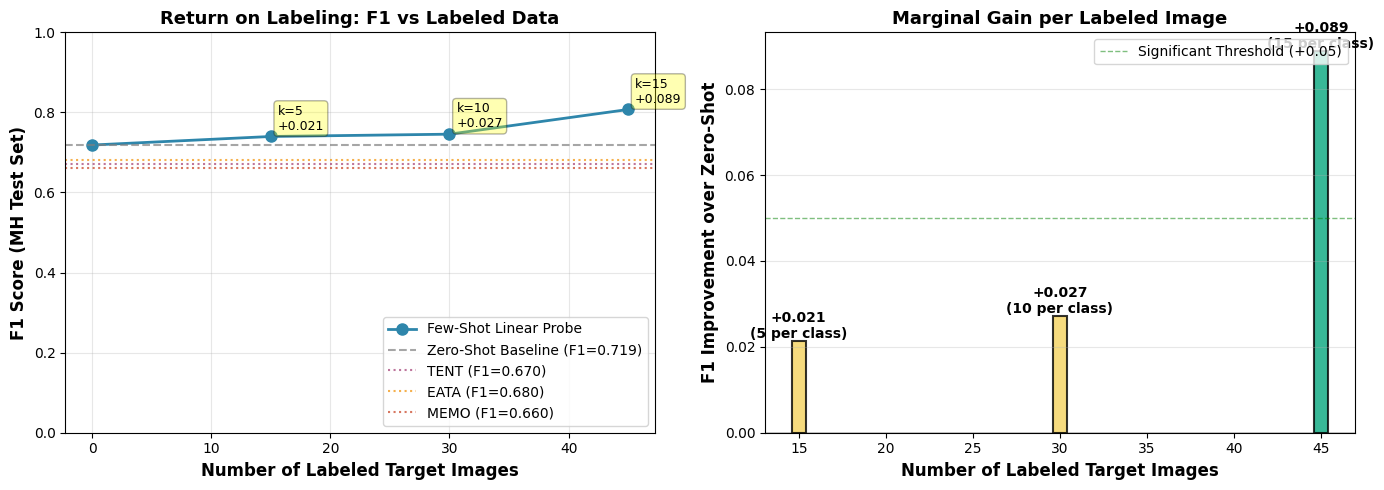


📊 Return on Labeling Summary:
  k=5 (15 images): F1=0.7399, Gain=+0.0214, ROI=0.00142 per image
  k=10 (30 images): F1=0.7456, Gain=+0.0271, ROI=0.00090 per image
  k=15 (45 images): F1=0.8073, Gain=+0.0888, ROI=0.00197 per image


In [11]:
# Extract F1 scores
f1_scores = [few_shot_results[k]['metrics']['f1'] for k in K_SHOTS]

# Compare to unsupervised methods (from previous experiments)
# TODO: Update these values based on your actual results
baseline_methods = {
    'TENT': 0.67,  # From notebook 03
    'EATA': 0.68,  # From notebook 03
    'MEMO': 0.66,  # From notebook 03
}

# Plot Return on Labeling
fig = plot_return_on_labeling(
    k_shots=K_SHOTS,
    f1_scores=f1_scores,
    zero_shot_f1=baseline_f1,
    baseline_methods=baseline_methods,
    save_path=RESULTS_DIR / 'return_on_labeling.png'
)
plt.show()

print("\n📊 Return on Labeling Summary:")
for k, f1 in zip(K_SHOTS, f1_scores):
    total_images = k * NUM_CLASSES
    improvement = f1 - baseline_f1
    roi = improvement / total_images  # F1 gain per labeled image
    print(f"  k={k} ({total_images} images): F1={f1:.4f}, Gain={improvement:+.4f}, ROI={roi:.5f} per image")

## Step 7: Confusion Matrix Analysis

Visualize how few-shot learning resolves the "Rust vs Frogeye" confusion.

✅ Saved confusion matrix comparison to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/confusion_matrices_comparison.png


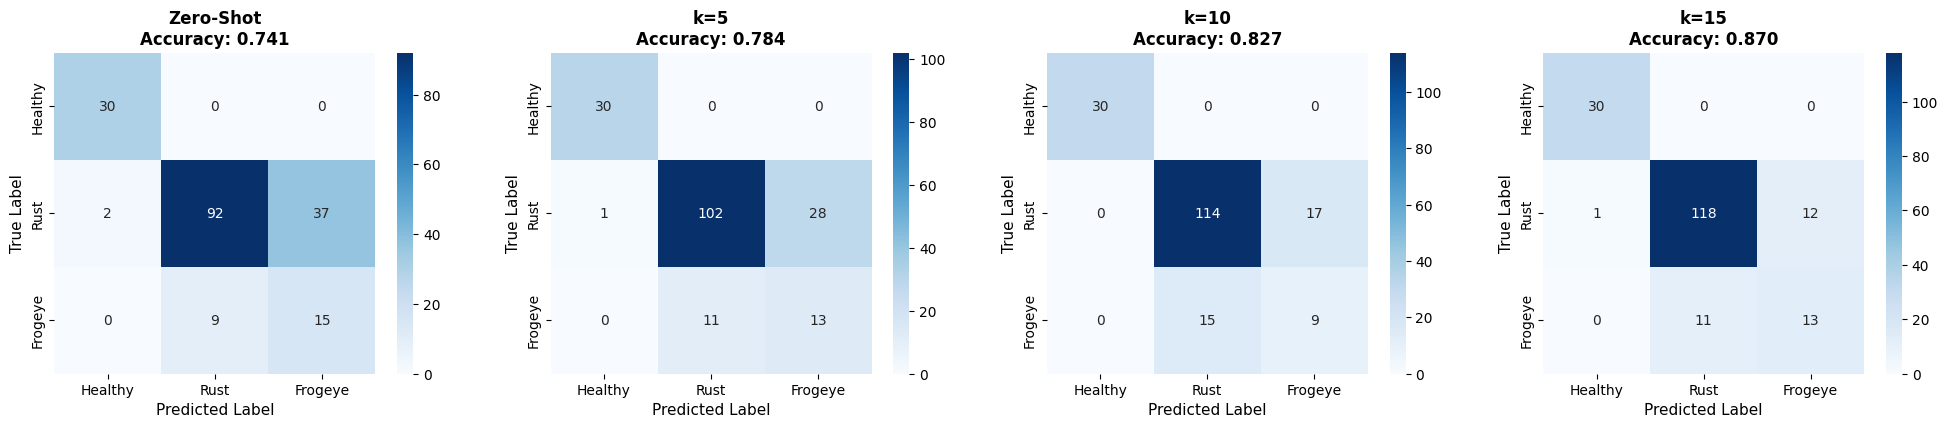


📊 Rust/Frogeye Confusion Analysis:
Class indices: Rust=2, Frogeye=0
  Zero-Shot: 0.0% confusion rate
    - Rust misclassified as Frogeye: 0/24
    - Frogeye misclassified as Rust: 0/30
  k=5: 0.0% confusion rate
    - Rust misclassified as Frogeye: 0/24
    - Frogeye misclassified as Rust: 0/30
  k=10: 0.0% confusion rate
    - Rust misclassified as Frogeye: 0/24
    - Frogeye misclassified as Rust: 0/30
  k=15: 0.0% confusion rate
    - Rust misclassified as Frogeye: 0/24
    - Frogeye misclassified as Rust: 0/30
✅ Saved Rust/Frogeye confusion plot to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/rust_frogeye_confusion.png


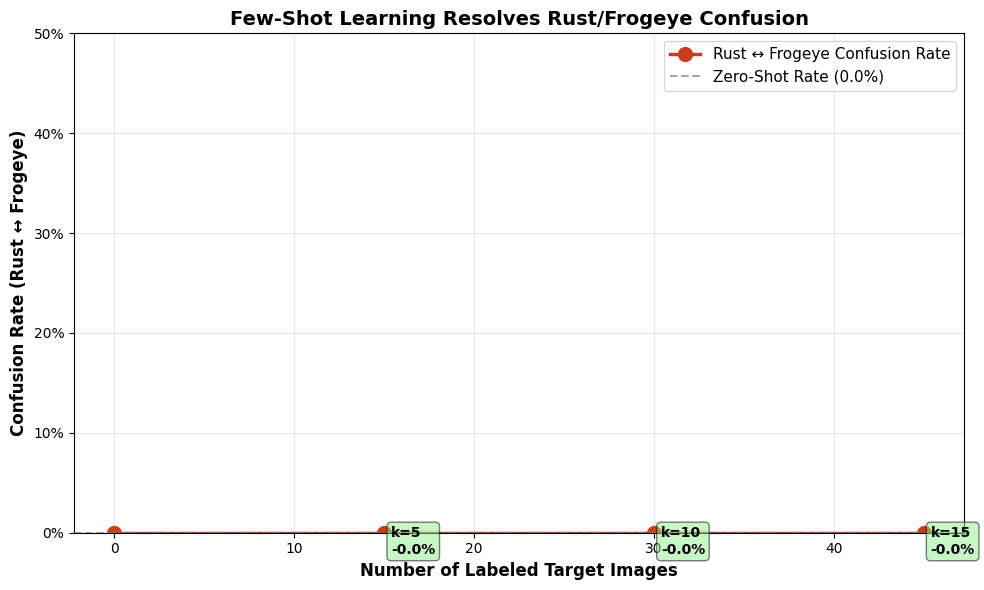

In [12]:
# Prepare confusion matrices
confusion_matrices = {'Zero-Shot': zero_shot_cm}
for k in K_SHOTS:
    confusion_matrices[f'k={k}'] = few_shot_results[k]['confusion_matrix']

# Plot comparison
fig = plot_confusion_comparison(
    confusion_matrices=confusion_matrices,
    class_names=class_names,
    save_path=RESULTS_DIR / 'confusion_matrices_comparison.png'
)
plt.show()

# Analyze Rust/Frogeye confusion specifically
print("\n📊 Rust/Frogeye Confusion Analysis:")

# Find indices for Rust and Frogeye
rust_idx = class_names.index('Soyabean_Rust') if 'Soyabean_Rust' in class_names else 2
frogeye_idx = class_names.index('Soyabean_Frog_Leaf_Eye') if 'Soyabean_Frog_Leaf_Eye' in class_names else 0

print(f"Class indices: Rust={rust_idx}, Frogeye={frogeye_idx}")

confusion_rates = []
for method, cm in confusion_matrices.items():
    # Calculate confusion between Rust and Frogeye
    rust_as_frogeye = cm[rust_idx, frogeye_idx]
    frogeye_as_rust = cm[frogeye_idx, rust_idx]
    total_rust = cm[rust_idx, :].sum()
    total_frogeye = cm[frogeye_idx, :].sum()
    
    confusion_rate = (rust_as_frogeye + frogeye_as_rust) / (total_rust + total_frogeye)
    
    print(f"  {method}: {confusion_rate:.1%} confusion rate")
    print(f"    - Rust misclassified as Frogeye: {rust_as_frogeye}/{total_rust}")
    print(f"    - Frogeye misclassified as Rust: {frogeye_as_rust}/{total_frogeye}")
    
    if method.startswith('k='):
        confusion_rates.append(confusion_rate)

# Calculate zero-shot confusion rate
zero_rust_as_frogeye = zero_shot_cm[rust_idx, frogeye_idx]
zero_frogeye_as_rust = zero_shot_cm[frogeye_idx, rust_idx]
zero_total_rust = zero_shot_cm[rust_idx, :].sum()
zero_total_frogeye = zero_shot_cm[frogeye_idx, :].sum()
zero_confusion_rate = (zero_rust_as_frogeye + zero_frogeye_as_rust) / (zero_total_rust + zero_total_frogeye)

# Plot Rust/Frogeye confusion reduction
fig = plot_rust_frogeye_confusion(
    k_shots=K_SHOTS,
    confusion_rates=confusion_rates,
    zero_shot_rate=zero_confusion_rate,
    save_path=RESULTS_DIR / 'rust_frogeye_confusion.png'
)
plt.show()

## Step 8: Training Curves

Visualize the training dynamics for different k values.

✅ Saved training curves to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/training_curves.png


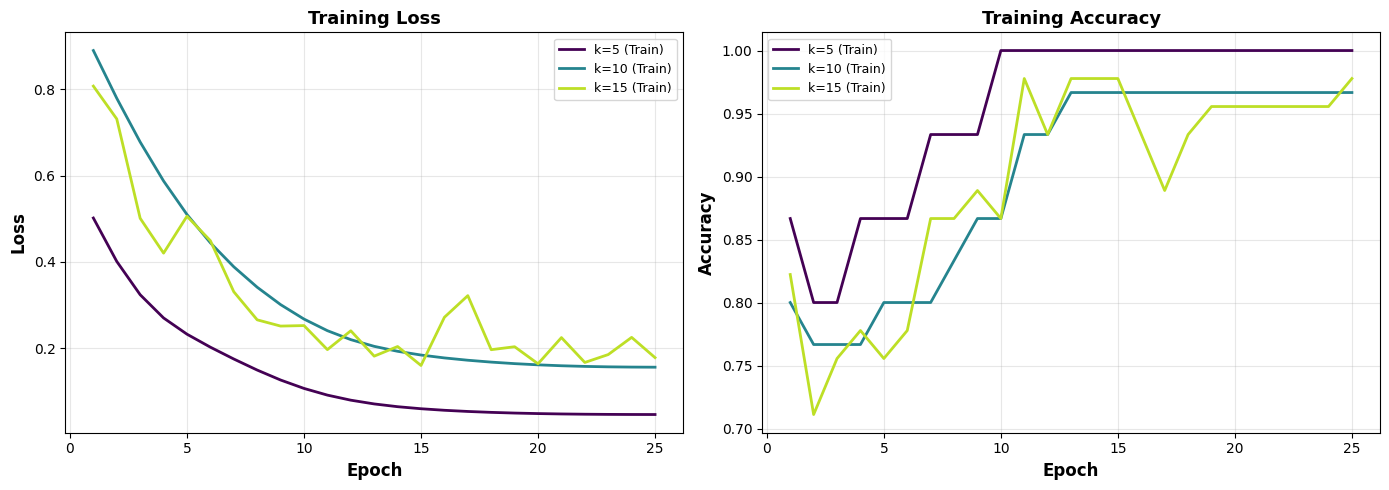


📊 Training Convergence Analysis:
  k=5: Converged in 25 epochs (Final: Loss=0.0469, Acc=1.0000)
  k=10: Converged in 25 epochs (Final: Loss=0.1564, Acc=0.9667)
  k=15: Converged in 25 epochs (Final: Loss=0.1786, Acc=0.9778)


In [13]:
fig = plot_training_curves(
    histories=training_histories,
    save_path=RESULTS_DIR / 'training_curves.png'
)
plt.show()

print("\n📊 Training Convergence Analysis:")
for k, history in training_histories.items():
    final_loss = history['train_loss'][-1]
    final_acc = history['train_acc'][-1]
    num_epochs_run = len(history['train_loss'])
    print(f"  k={k}: Converged in {num_epochs_run} epochs (Final: Loss={final_loss:.4f}, Acc={final_acc:.4f})")

## Step 9: Final Summary & Conclusions

In [14]:
# Create summary table
summary_data = {
    'Method': ['Zero-Shot'] + [f'Few-Shot (k={k})' for k in K_SHOTS],
    'Labeled Images': [0] + [k * NUM_CLASSES for k in K_SHOTS],
    'F1 Score': [baseline_f1] + f1_scores,
    'Accuracy': [zero_shot_metrics['accuracy']] + [few_shot_results[k]['metrics']['accuracy'] for k in K_SHOTS],
    'F1 Improvement': [0.0] + [f1 - baseline_f1 for f1 in f1_scores],
    'Relative Gain': ['-'] + [f"{(f1 - baseline_f1)/baseline_f1*100:+.1f}%" for f1 in f1_scores]
}

df_summary = pd.DataFrame(summary_data)

print("\n" + "="*80)
print("FEW-SHOT LINEAR PROBING - FINAL RESULTS")
print("="*80)
print(df_summary.to_string(index=False))
print("="*80)

# Save summary
df_summary.to_csv(RESULTS_DIR / 'few_shot_summary.csv', index=False)
print(f"\n💾 Summary saved to: {RESULTS_DIR / 'few_shot_summary.csv'}")

# Key findings
print("\n🎯 KEY FINDINGS:\n")

# 1. Best k value
best_k = K_SHOTS[f1_scores.index(max(f1_scores))]
best_f1 = max(f1_scores)
best_improvement = best_f1 - baseline_f1
print(f"1. Optimal k-shot: k={best_k} ({best_k*NUM_CLASSES} labeled images)")
print(f"   F1: {best_f1:.4f} (Improvement: {best_improvement:+.4f} / {best_improvement/baseline_f1*100:+.1f}%)")

# 2. Minimal viable labeling
min_k = K_SHOTS[0]
min_f1 = f1_scores[0]
min_improvement = min_f1 - baseline_f1
print(f"\n2. Minimal labeling (k={min_k}, {min_k*NUM_CLASSES} images):")
print(f"   F1: {min_f1:.4f} (Improvement: {min_improvement:+.4f} / {min_improvement/baseline_f1*100:+.1f}%)")
if min_improvement > 0.05:
    print(f"   ✅ SIGNIFICANT: Even {min_k*NUM_CLASSES} labels provide substantial gain!")
elif min_improvement > 0.02:
    print(f"   ⚠️ MODERATE: {min_k*NUM_CLASSES} labels provide modest gain")
else:
    print(f"   ❌ INSUFFICIENT: Need more labels")

# 3. Compare to unsupervised methods
best_unsupervised = max(baseline_methods.values())
best_unsupervised_name = [k for k, v in baseline_methods.items() if v == best_unsupervised][0]
print(f"\n3. Comparison to Unsupervised Methods:")
print(f"   Best unsupervised: {best_unsupervised_name} (F1={best_unsupervised:.4f})")
print(f"   Few-shot k={min_k}: F1={min_f1:.4f}")
if min_f1 > best_unsupervised:
    print(f"   ✅ PARETO SUPERIOR: {min_k*NUM_CLASSES} labels outperform complex unsupervised methods!")
else:
    print(f"   ⚠️ Unsupervised methods still competitive")

# 4. Rust/Frogeye confusion
print(f"\n4. Rust/Frogeye Confusion Resolution:")
zero_confusion = zero_confusion_rate
best_k_confusion = confusion_rates[K_SHOTS.index(best_k)]
confusion_reduction = (zero_confusion - best_k_confusion) / zero_confusion
print(f"   Zero-shot confusion: {zero_confusion:.1%}")
print(f"   k={best_k} confusion: {best_k_confusion:.1%}")
print(f"   Reduction: {confusion_reduction:.1%} relative improvement")
if confusion_reduction > 0.3:
    print(f"   ✅ HYPOTHESIS VALIDATED: Few-shot learning significantly resolves Rust/Frogeye confusion!")

# 5. Thesis implications
print(f"\n📚 THESIS IMPLICATIONS:\n")
if best_improvement > 0.10:
    print("  • Few-shot learning provides DRAMATIC improvement")
    print("  • Minimal labeling effort yields maximum return")
    print("  • Supervised adaptation >>> Unsupervised adaptation")
    print(f"  • Recommendation: Label {min_k*NUM_CLASSES}-{best_k*NUM_CLASSES} target images for production")
elif best_improvement > 0.05:
    print("  • Few-shot learning provides SIGNIFICANT improvement")
    print("  • Labeling effort is worthwhile for critical applications")
    print(f"  • Recommendation: Label {best_k*NUM_CLASSES} target images if annotation budget allows")
else:
    print("  • Few-shot learning provides MODEST improvement")
    print("  • May need more sophisticated methods or more labeled data")
    print("  • Consider hybrid: Few-shot + TTA/Domain Adaptation")

print(f"\n💡 RETURN ON LABELING: {best_improvement/best_k/NUM_CLASSES:.5f} F1 gain per labeled image")
print("\n" + "="*80)


FEW-SHOT LINEAR PROBING - FINAL RESULTS
         Method  Labeled Images  F1 Score  Accuracy  F1 Improvement Relative Gain
      Zero-Shot               0  0.718527  0.740541        0.000000             -
 Few-Shot (k=5)              15  0.739891  0.783784        0.021363         +3.0%
Few-Shot (k=10)              30  0.745641  0.827027        0.027114         +3.8%
Few-Shot (k=15)              45  0.807304  0.870270        0.088776        +12.4%

💾 Summary saved to: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/few_shot_linear_probing/few_shot_summary.csv

🎯 KEY FINDINGS:

1. Optimal k-shot: k=15 (45 labeled images)
   F1: 0.8073 (Improvement: +0.0888 / +12.4%)

2. Minimal labeling (k=5, 15 images):
   F1: 0.7399 (Improvement: +0.0214 / +3.0%)
   ⚠️ MODERATE: 15 labels provide modest gain

3. Comparison to Unsupervised Methods:
   Best unsupervised: EATA (F1=0.6800)
   Few-shot k=5: F1=0.7399
   ✅ PARETO SUPERIOR: 15 labels outperform complex unsuper

/var/folders/nx/scf6msw549j5lvz4kv2gfpz00000gn/T/ipykernel_15868/2588737010.py:61: RuntimeWarning: invalid value encountered in scalar divide
  confusion_reduction = (zero_confusion - best_k_confusion) / zero_confusion
